## Problem.1

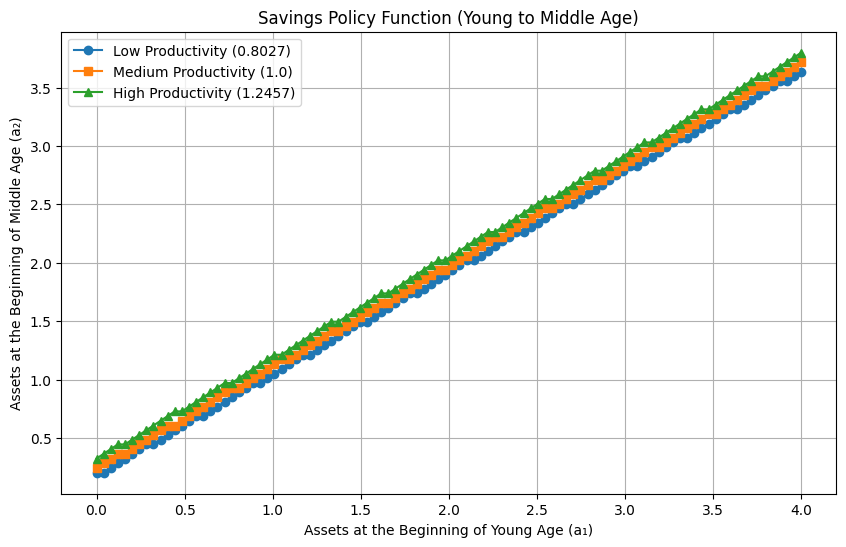

In [16]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# Parameters
gamma = 2.0
beta = 0.985**20
r = 1.025**20 - 1.0
JJ = 3 # Number of periods
l = np.array([0.8027, 1.0, 1.2457]) # Productivity levels
NL = 3 # Number of productivity levels

# Transition matrix for middle-age income uncertainty
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])

# Grids
a_l = 0.0
a_u = 4.0 # Upper bound for assets can be adjusted
NA = 100
a = np.linspace(a_l, a_u, NA)

# Utility function
def util(c, gamma):
    if c > 0:
        return (c**(1 - gamma)) / (1 - gamma)
    else:
        # Return a large negative number for non-positive consumption
        return -np.inf

# Initialization
v = np.zeros((JJ, NA, NL)) # Value function for 3 periods
iaplus = np.zeros((JJ-1, NA, NL), dtype=int) # Policy function indices
aplus = np.zeros((JJ-1, NA, NL)) # Savings policy function for young and middle age

# --- Backward Induction ---

# Period 3 (Old Age): No labor income
for ia in range(NA):
    v[2, ia, :] = util((1.0 + r) * a[ia], gamma)

# Period 2 (Middle Age): Solves for savings from middle to old age
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v[2, iap, 0]
        
        iaplus[1, ia, il] = np.argmax(reward)
        aplus[1, ia, il] = a[iaplus[1, ia, il]]
        v[1, ia, il] = np.max(reward)

# Period 1 (Young Age): Solves for savings from young to middle age
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            
            EV = 0.0
            for ilp in range(NL):
                EV += prob[il, ilp] * v[1, iap, ilp]
            
            # CORRECTED: Added interest (1.0 + r) to the initial asset a[ia]
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        
        iaplus[0, ia, il] = np.argmax(reward)
        aplus[0, ia, il] = a[iaplus[0, ia, il]]
        v[0, ia, il] = reward[iaplus[0, ia, il]]

# --- Plotting the Results for Problem 1 ---

plt.figure(figsize=(10, 6))
plt.plot(a, aplus[0, :, 0], marker='o', linestyle='-', label='Low Productivity (0.8027)')
plt.plot(a, aplus[0, :, 1], marker='s', linestyle='-', label='Medium Productivity (1.0)')
plt.plot(a, aplus[0, :, 2], marker='^', linestyle='-', label='High Productivity (1.2457)')
plt.title("Savings Policy Function (Young to Middle Age)")
plt.xlabel("Assets at the Beginning of Young Age (a₁)")
plt.ylabel("Assets at the Beginning of Middle Age (a₂)")
plt.legend()
plt.grid(True)
plt.show()

## Problem.2

Total Tax Revenue: 0.3043
Per-Person Pension Benefit: 0.4986


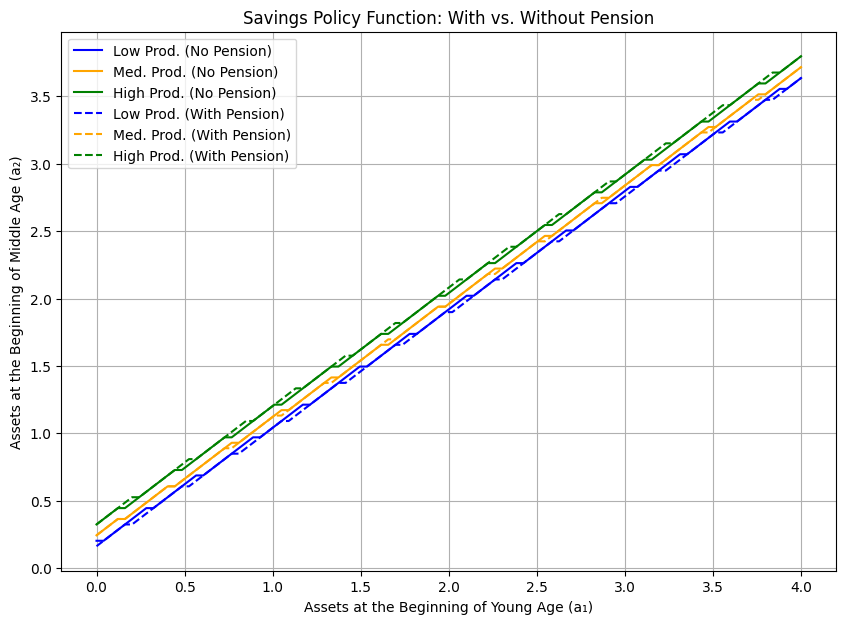

In [17]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

# --- Parameters (Same as Problem 1) ---
gamma = 2.0
beta = 0.985**20
r = 1.025**20 - 1.0
JJ = 3
l = np.array([0.8027, 1.0, 1.2457])
NL = 3
prob = np.array([
    [0.7451, 0.2528, 0.0021],
    [0.1360, 0.7281, 0.1360],
    [0.0021, 0.2528, 0.7451]
])
a_l = 0.0
a_u = 4.0
NA = 100
a = np.linspace(a_l, a_u, NA)

# Utility function
def util(c, gamma):
    if c > 0:
        return (c**(1 - gamma)) / (1 - gamma)
    else:
        return -np.inf

# --- Solve for Policy Function WITHOUT Pension (from Problem 1) ---
v_no_pension = np.zeros((JJ, NA, NL))
aplus_no_pension = np.zeros((JJ - 1, NA, NL))
# Period 3
for ia in range(NA):
    v_no_pension[2, ia, :] = util((1.0 + r) * a[ia], gamma)
# Period 2
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_no_pension[2, iap, 0]
        aplus_no_pension[1, ia, il] = a[np.argmax(reward)]
        v_no_pension[1, ia, il] = np.max(reward)
# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_no_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_no_pension[0, ia, il] = a[np.argmax(reward)]

# --- Calculate Tax Revenue and Pension Benefit ---
tax_rate = 0.30
mu_1 = np.full(NL, 1.0/NL)
mu_2 = mu_1 @ prob
average_labor_income_mid = np.sum(mu_2 * l)
total_tax_revenue = average_labor_income_mid * tax_rate
pension_benefit = total_tax_revenue * (1.0 + r)

print(f"Total Tax Revenue: {total_tax_revenue:.4f}")
print(f"Per-Person Pension Benefit: {pension_benefit:.4f}")

# --- Solve for Policy Function WITH Pension ---
v_pension = np.zeros((JJ, NA, NL))
aplus_pension = np.zeros((JJ - 1, NA, NL))
# Period 3 (with pension)
for ia in range(NA):
    consumption = (1.0 + r) * a[ia] + pension_benefit
    v_pension[2, ia, :] = util(consumption, gamma)
# Period 2 (with tax)
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            consumption = l[il] * (1 - tax_rate) + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * v_pension[2, iap, 0]
        aplus_pension[1, ia, il] = a[np.argmax(reward)]
        v_pension[1, ia, il] = np.max(reward)
# Period 1
for il in range(NL):
    for ia in range(NA):
        reward = np.full(NA, -np.inf)
        for iap in range(NA):
            EV = np.sum(prob[il, :] * v_pension[1, iap, :])
            consumption = l[il] + (1.0 + r) * a[ia] - a[iap]
            if consumption > 0:
                reward[iap] = util(consumption, gamma) + beta * EV
        aplus_pension[0, ia, il] = a[np.argmax(reward)]

# --- Plotting the Comparison ---
plt.figure(figsize=(10, 7))
# No Pension lines
plt.plot(a, aplus_no_pension[0, :, 0], color='blue', linestyle='-', label='Low Prod. (No Pension)')
plt.plot(a, aplus_no_pension[0, :, 1], color='orange', linestyle='-', label='Med. Prod. (No Pension)')
plt.plot(a, aplus_no_pension[0, :, 2], color='green', linestyle='-', label='High Prod. (No Pension)')
# With Pension lines
plt.plot(a, aplus_pension[0, :, 0], color='blue', linestyle='--', label='Low Prod. (With Pension)')
plt.plot(a, aplus_pension[0, :, 1], color='orange', linestyle='--', label='Med. Prod. (With Pension)')
plt.plot(a, aplus_pension[0, :, 2], color='green', linestyle='--', label='High Prod. (With Pension)')

plt.title("Savings Policy Function: With vs. Without Pension")
plt.xlabel("Assets at the Beginning of Young Age (a₁)")
plt.ylabel("Assets at the Beginning of Middle Age (a₂)")
plt.legend()
plt.grid(True)
plt.show()